In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16 # VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 # ResNet50



from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Set the seed value for experiment reproduci.bility.
seed = 1842
tensorflow.random.set_seed(seed)
np.random.seed(seed)
# Turn off warnings for cleaner looking notebook
warnings.simplefilter('ignore')

In [ ]:
img_gen = ImageDataGenerator(rescale=1/255, validation_split=0)
train_data = img_gen.flow_from_directory(batch_size=16,
                                                 directory='/content/drive/MyDrive/Alzheimer_s/train',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 subset="training",
                                                 class_mode='categorical')

Found 5121 images belonging to 4 classes.


In [ ]:
img_gen = ImageDataGenerator(rescale=1/255,validation_split=0.2)
validation_dataset = img_gen.flow_from_directory(batch_size=16,
                                                 directory='/content/drive/MyDrive/Alzheimer_s/test',
                                                 shuffle=True,
                                                 target_size=(224,224),
                                                 class_mode='categorical')

Found 1279 images belonging to 4 classes.


In [ ]:
submission = img_gen.flow_from_directory(
                                                 directory='/content/drive/MyDrive/Alzheimer_s/test',
                                                 shuffle=False,
                                                subset="validation",
                                                 target_size=(224,224),
                                                 class_mode=None)

Found 254 images belonging to 4 classes.


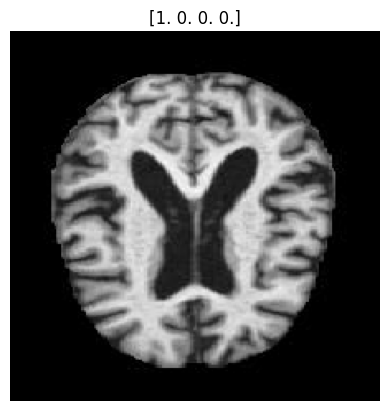

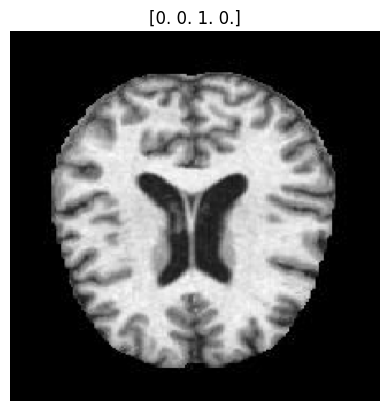

In [ ]:
batch_1_img = train_data[0]
for i in range(0,2):
    img = batch_1_img[0][i]
    lab = batch_1_img[1][i]
    plt.imshow(img)
    plt.title(lab)
    plt.axis('off')
    plt.show()

In [ ]:
rn = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
for layer in rn.layers:
    layer.trainable = False
x = Flatten()(rn.output)
x = Dropout(0.25)(x)
prediction = Dense(4, activation='softmax')(x)

modelvgg = Model(inputs=rn.input, outputs=prediction)
modelvgg.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [ ]:
modelvgg.compile(optimizer='adam',
loss=tensorflow.losses.CategoricalCrossentropy(),
metrics=[keras.metrics.AUC(name='auc'),'acc'])
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=8,
                                            restore_best_weights=True)

In [ ]:
modelvgg.fit(train_data, epochs=50, validation_data=validation_dataset, callbacks=callback)

Epoch 1/50
321/321 [==============================] - 31s 84ms/step - loss: 1.9392 - auc: 0.7508 - acc: 0.4802 - val_loss: 1.2757 - val_auc: 0.8001 - val_acc: 0.4973
Epoch 2/50
321/321 [==============================] - 26s 79ms/step - loss: 1.8242 - auc: 0.7826 - acc: 0.5153 - val_loss: 1.3869 - val_auc: 0.8222 - val_acc: 0.5676
Epoch 3/50
321/321 [==============================] - 25s 78ms/step - loss: 1.6561 - auc: 0.8071 - acc: 0.5552 - val_loss: 1.0246 - val_auc: 0.8100 - val_acc: 0.5090
Epoch 4/50
321/321 [==============================] - 25s 78ms/step - loss: 1.5780 - auc: 0.8166 - acc: 0.5536 - val_loss: 1.2655 - val_auc: 0.7789 - val_acc: 0.4754
Epoch 5/50
321/321 [==============================] - 25s 79ms/step - loss: 1.5312 - auc: 0.8231 - acc: 0.5718 - val_loss: 2.0928 - val_auc: 0.8022 - val_acc: 0.5708
Epoch 6/50
321/321 [==============================] - 25s 78ms/step - loss: 1.4955 - auc: 0.8335 - acc: 0.5895 - val_loss: 1.2986 - val_auc: 0.7602 - val_acc: 0.4527
Epoc

In [ ]:
loss, auc, accuracy = modelvgg.evaluate(validation_dataset)
print("Loss: ", loss)
print("AUC: ", auc)
print("Accuracy: ", accuracy)

80/80 [==============================] - 5s 62ms/step - loss: 1.0246 - auc: 0.8100 - acc: 0.5090
Loss:  1.0246254205703735
AUC:  0.8100069165229797
Accuracy:  0.5089914202690125
